### Imports

In [53]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
from tqdm import tqdm
import math
%matplotlib inline

### Functions

In [69]:
def train(Xtr, Ytr, dim_embed, n_epochs=200000) -> tuple:
  g = torch.Generator().manual_seed(2147483647) # for reproducibility
  C = torch.randn((27, dim_embed), generator=g)
  W1 = torch.randn((3 * dim_embed, 200), generator=g)
  b1 = torch.randn(200, generator=g)
  W2 = torch.randn((200, 27), generator=g)
  b2 = torch.randn(27, generator=g)
  parameters = [C, W1, b1, W2, b2]
  for p in parameters:
    p.requires_grad = True

  for i in tqdm(range(n_epochs)):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 10)
    h = torch.tanh(emb.view(-1, math.prod(emb.shape[1:])) @ W1 + b1) # (32, 200)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    # tqdm.write(f"{loss=:.4f}")
    
    # backward pass
    for p in parameters:
      p.grad = None
    loss.backward()
    
    # update
    #lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
      p.data += -lr * p.grad

    # track stats
    #lri.append(lre[i])
    # stepi.append(i)
    # lossi.append(loss.log10().item())

  print(loss.item())
  return C, W1, b1, W2, b2

def eval_loss(Xtr, Ytr, C, W1, b1, W2, b2):
  emb = C[Xtr] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, math.prod(emb.shape[1:])) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr)
  return loss.item()

### Build dataset

In [6]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [7]:
len(words)

32033

In [8]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [9]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [10]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [11]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [12]:
C = torch.randn((27, 2))

In [13]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [14]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [15]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [16]:
h

tensor([[-0.9961,  0.9930, -0.5910,  ...,  0.9991, -0.9948,  0.9489],
        [-0.9802,  1.0000,  0.7359,  ...,  0.9999,  0.9999,  0.9898],
        [-0.9984,  1.0000,  0.9929,  ...,  0.7352,  0.9997, -0.7668],
        ...,
        [-0.9604, -0.9607, -0.9359,  ...,  0.9994, -0.9928,  0.7559],
        [-0.9958, -0.9804, -0.9484,  ...,  0.9976, -0.9911, -0.2395],
        [-0.1893,  0.8610, -0.6565,  ...,  0.9963, -0.9772,  0.9249]])

In [17]:
h.shape

torch.Size([228146, 100])

In [18]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [19]:
logits = h @ W2 + b2

In [20]:
logits.shape

torch.Size([228146, 27])

In [21]:
counts = logits.exp()

In [22]:
prob = counts / counts.sum(1, keepdims=True)

In [23]:
prob.shape, Y.shape, prob.shape[0]

(torch.Size([228146, 27]), torch.Size([228146]), 228146)

In [24]:
loss = -prob[torch.arange(prob.shape[0]), Y].log().mean()
loss

tensor(17.7722)

In [ ]:
# ------------ now made respectable :) ---------------

In [26]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [28]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [30]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [31]:
lri = []
lossi = []
stepi = []

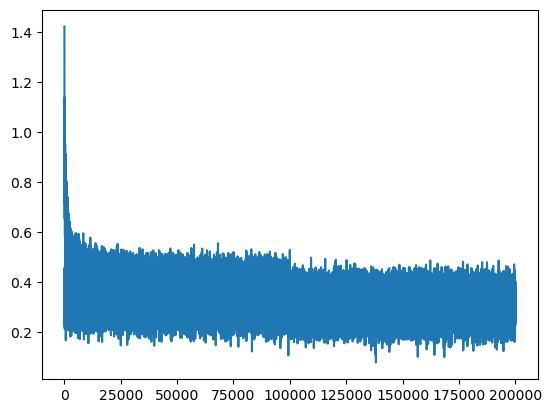

In [36]:
plt.plot(stepi, lossi)

### Train

In [70]:
C, W1, b1, W2, b2 = train(Xtr, Ytr, 10, n_epochs=10)
loss_train = eval_loss(Xtr, Ytr, C, W1, b1, W2, b2)
loss_val = eval_loss(Xdev, Ydev, C, W1, b1, W2, b2)
print(f'{loss_train=:.4f}, {loss_val=:.4f}')

100%|██████████| 10/10 [00:00<00:00, 60.19it/s]


18.887073516845703
loss_train=18.0709, loss_val=18.0671


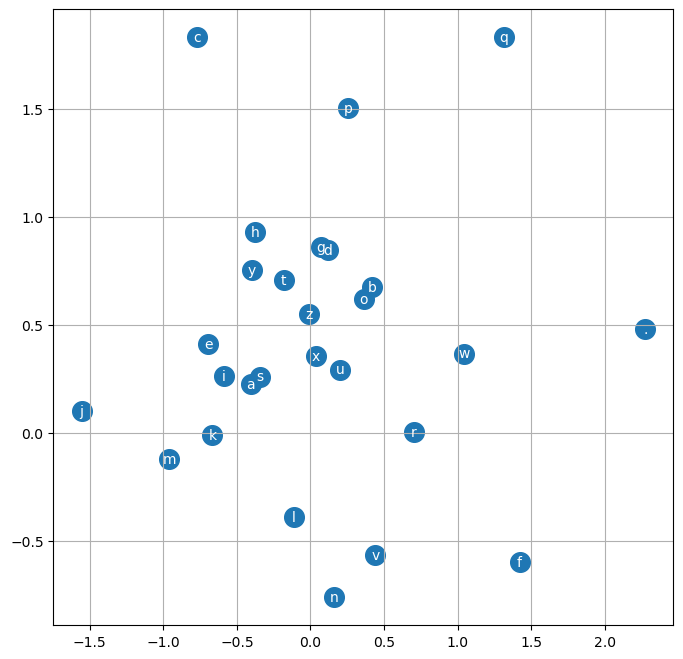

In [39]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [40]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [41]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmah.
amelle.
khyrilli.
taty.
skanden.
jazhitlangelynn.
kaeli.
ner.
kiah.
maiir.
kaleigh.
ham.
pris.
quint.
shoilea.
jadbi.
wajero.
dearisi.
jaxen.
drraylen.


### Exercises

- E01: Tune the hyperparameters of the training to beat my best validation loss of 2.2
- E02: I was not careful with the intialization of the network in this video. (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?
- E03: Read the Bengio et al 2003 paper (link above), implement and try any idea from the paper. Did it work?